# Download Dataset

In [1]:
# Import Libraries
import json
import nltk
import random
import string
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Flatten, Dense, GlobalMaxPool1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Download Packages

In [2]:
# package for tokenizing data
nltk.download('punkt')

# package for lemmatization
nltk.download('wordnet')

# package for multilingual wordnet
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# 1. Read Data

In [3]:
# Importing the dataset
# DO: Masukkan path file data kampus_merdeka.json
with open('/content/chatbot.json' ) as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = []
inputs = []
responses = {}
words = []
classes = []
documents = []
ignore_words = ['?', '!']


for intent in data1['intents']:
  # Mengumpulkan semua response
  responses[intent['tag']]= intent['responses']

  # Mengumpulkan semua patterns dan tags
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])

    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)


# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns": inputs, "tags": tags})

In [4]:
# DO: Menampilkan data index ke-15 sampai 19
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
113,Iya,respon_sudah
114,Ya,respon_sudah
115,Belum,respon_belum
116,Blum,respon_belum


# 2. Data Preprocessing

## Removing Punctuation

In [5]:
# Character punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
# Mengubah data ke format huruf kecil dan menghilangkan punctuation
# DO: Masukkan kolom 'patterns' untuk dilakukan punctuation
data['patterns'] = data['patterns'].apply(lambda word:[letters.lower() for letters in word if letters not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda word: ''.join(word))

# Menampilkan hasil
data[15 : 20]

,patterns,tags
15,apa itu kidneybot,kidneybot
16,siapa kidneybot,kidneybot
17,apa tugasmu,kidneybot
18,apa itu kidneybot,kidneybot
19,siapa kidneybot,kidneybot


## Tokenizer

In [7]:
# Tokenize the data
# DO: Atur num_words sebanyak 2000
tokenizer = Tokenizer(num_words= 2000)

# DO: Masukkan kolom patterns kedalam fit_on_texts
tokenizer.fit_on_texts(data['patterns'])
# DO: Masukkan kolom patterns kedalam texts_to_sequences
tokenized_data = tokenizer.texts_to_sequences(data['patterns'] )

# Menampilkan data ke-15 sampai ke-20
print('Sebelum dilakukan tokenisasi:\n')
print(data['patterns'][15 : 20])

# Menampilkan hasil tokenisasi data ke-15 sampai ke-20
print('\n\nSesudah dilakukan tokenisasi:\n')
print(tokenized_data[15 : 20])

Sebelum dilakukan tokenisasi:

15    apa itu kidneybot
16      siapa kidneybot
17          apa tugasmu
18    apa itu kidneybot
19      siapa kidneybot
Name: patterns, dtype: object


Sesudah dilakukan tokenisasi:

[[2, 30, 23], [42, 23], [2, 77], [2, 30, 23], [42, 23]]


## Padding

In [8]:
# Melakukan padding terhadap hasil tokenisasi
# DO: Masukkan hasil tokenisasi kedalam pad_sequences
x_train = pad_sequences(tokenized_data)

# Menampilkan hasil padding
print('Hasil padding:\n')
print(x_train[15:20])

Hasil padding:

[[ 0  0  0  0  0  0  0  0  0  0  2 30 23]
 [ 0  0  0  0  0  0  0  0  0  0  0 42 23]
 [ 0  0  0  0  0  0  0  0  0  0  0  2 77]
 [ 0  0  0  0  0  0  0  0  0  0  2 30 23]
 [ 0  0  0  0  0  0  0  0  0  0  0 42 23]]


## Encoding Label

In [9]:
# Encoding the label
# DO: Panggil fungsi LabelEncoder()
le = LabelEncoder()

# DO: Masukkan kolom tags sebagai label data ke dalam fit_transform
y_train = le.fit_transform(data['tags'])

# Menampilkan label sebelum di-encoding
print('Label sebelum di-encoding:\n')
print(data['tags'])

# Menampilkan label setelah di-encoding
print('\n\nLabel setelah di-encoding:\n')
print(y_train)

Label sebelum di-encoding:

0          greeting
1          greeting
2          greeting
3          greeting
4          greeting
           ...     
113    respon_sudah
114    respon_sudah
115    respon_belum
116    respon_belum
117    respon_belum
Name: tags, Length: 118, dtype: object


Label setelah di-encoding:

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  0  0  0  0
  0  0  0  0  0  0  0  6  6  6  6  6 10 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  4  4  4  4
  4  4  4  4  4  4  4  4  7  7  7  7  7  7  7  7  7  7  7  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  3  3  3  3  3  3  9  9  9  9  8  8  8]


# 3. Modelling and Evaluation

## Defining Input and Output

In [10]:
# Menentukan input shape
input_shape = x_train.shape[1]
print('input shape:', input_shape)

# Menentukan jumlah vocab
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# Menentukan panjang output
output_length = le.classes_.shape[0]
print("output length: ", output_length)

input shape: 13
number of unique words :  141
output length:  12


In [11]:
import joblib
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(tokenizer, 'tokenizer.joblib')

['tokenizer.joblib']

## Build Model

In [12]:
# Membuat Input layer
input_layer = Input(shape=(input_shape,))

# Membuat Hidden layer
layer = Embedding(vocabulary+1,10)(input_layer)
layer = LSTM(10, return_sequences=True)(layer)
layer = Flatten()(layer)

# Membuat Output layer
layer = Dense(output_length, activation="softmax")(layer)

# DO: Gabungkan input_layer dan layer kedalam fungsi Model!
model  = Model(input_layer,layer)

# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

## Training
Data yang dibutuhkan untuk training adalah data hasil preprocessing dan data label hasil encoding

In [13]:
# Melakukan training
# DO: Masukkan data yang akan ditraining (data hasil padding dan data hasil label encoding) dan atur epochs = 200!
train = model.fit( x_train, y_train, epochs=300)

Epoch 1/300
4/4 [==============================] - 3s 102ms/step - loss: 2.4849 - accuracy: 0.1356
Epoch 2/300
4/4 [==============================] - 1s 152ms/step - loss: 2.4782 - accuracy: 0.1864
Epoch 3/300
4/4 [==============================] - 1s 212ms/step - loss: 2.4720 - accuracy: 0.2119
Epoch 4/300
4/4 [==============================] - 0s 155ms/step - loss: 2.4653 - accuracy: 0.2458
Epoch 5/300
4/4 [==============================] - 0s 81ms/step - loss: 2.4577 - accuracy: 0.2542
Epoch 6/300
4/4 [==============================] - 0s 161ms/step - loss: 2.4478 - accuracy: 0.2542
Epoch 7/300
4/4 [==============================] - 0s 8ms/step - loss: 2.4366 - accuracy: 0.2373
Epoch 8/300
4/4 [==============================] - 0s 83ms/step - loss: 2.4238 - accuracy: 0.2203
Epoch 9/300
4/4 [==============================] - 0s 8ms/step - loss: 2.4073 - accuracy: 0.2203
Epoch 10/300
4/4 [==============================] - 0s 158ms/step - loss: 2.3896 - accuracy: 0.2288
Epoch 11/300
4/

## Evaluation

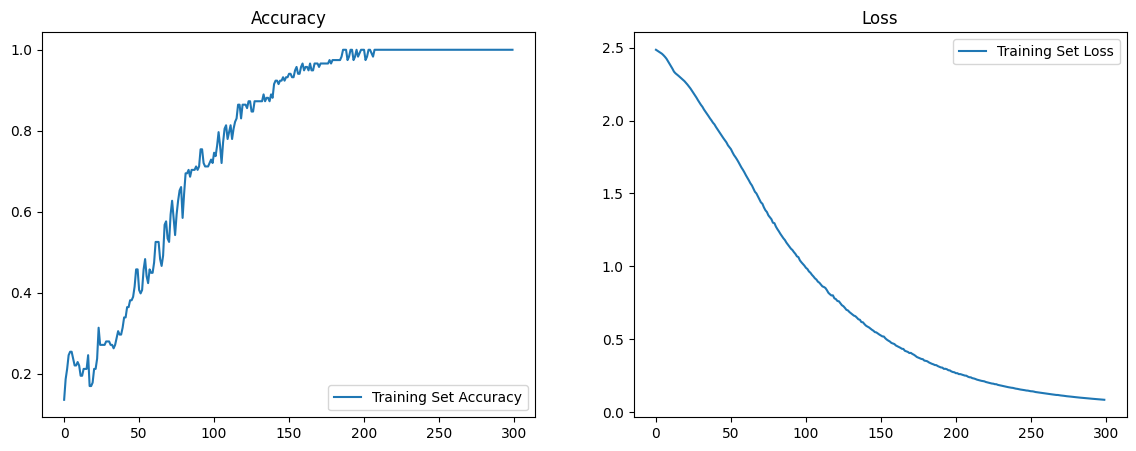

In [14]:
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# 4. Testing

In [15]:
from nltk.translate.gale_church import LanguageIndependent
while True:
  texts_p = []
  prediction_input = input('Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("Kidneybot : ", random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

Kamu : bye
1/1 [==============================] - 0s 385ms/step
Kidneybot :  Sampai jumpa lagi!


In [16]:
model.save('chatbot_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
